In [86]:
import numpy as np
from matplotlib import pyplot as plt


from matplotlib import cbook, cm
from matplotlib.colors import LightSource

https://towardsdatascience.com/master-positional-encoding-part-i-63c05d90a0c3

In [34]:
#### Numpy version ####
def positional_encoding(max_position, d_model, min_freq=1e-4):
    position = np.arange(max_position)
    freqs = min_freq**(2*(np.arange(d_model)//2)/d_model) # Come in "pairs" of frequencies
    pos_enc = position.reshape(-1,1)*freqs.reshape(1,-1) # shape = (max_pos, d_model)
    pos_enc[:, ::2] = np.cos(pos_enc[:, ::2])
    pos_enc[:, 1::2] = np.sin(pos_enc[:, 1::2])
    return pos_enc

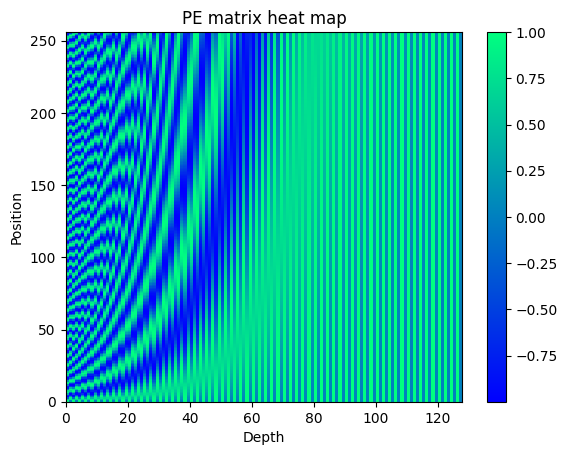

In [35]:
### Plotting ####
d_model = 128
max_pos = 256
mat = positional_encoding(max_pos, d_model)
plt.pcolormesh(mat, cmap='winter')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.title("PE matrix heat map")
plt.colorbar()
plt.show()

In [213]:
# Assumes square input
def positional_encoding_2D(positions, d_model, min_freq=1e-4):
    pos_d0 = positions[:,0]
    pos_d1 = positions[:,1]
    
    # Come in "pairs" of frequencies
    freqs = min_freq**(2*(np.arange(d_model)//2)/d_model) 
    
    pos_enc_d0 = pos_d0.reshape(-1,1) * freqs.reshape(1, -1)
    pos_enc_d1 = pos_d1.reshape(-1,1) * freqs.reshape(1, -1)
    
    pos_enc_d0[:, ::2] = np.cos(pos_enc_d0[:, ::2])
    pos_enc_d0[:, 1::2] = np.sin(pos_enc_d0[:, 1::2])
    
    pos_enc_d1[:, ::2] = np.cos(pos_enc_d1[:, ::2])
    pos_enc_d1[:, 1::2] = np.sin(pos_enc_d1[:, 1::2])
    
    return np.concatenate([pos_enc_d0, pos_enc_d1], axis=1)
    # return np.stack([pos_enc_d0, pos_enc_d1], axis=1)

In [228]:
# Modified for 2D array
n=256
positions = np.mgrid[0:n:1, 0:n:1].reshape(2,-1).T
# print(positions)

# d_model is essentially how many dimensional pairs to embed
d_model = 128

pos_enc = positional_encoding_2D(positions, d_model)
# for i, j in zip(positions, pos_enc):
#     print(i[0], '\n', j[0], '\n-----')
#     print(i[1], '\n', j[1], '\n=====')

Convert numpy version to pytorch

In [230]:
import torch

In [235]:
# Assumes square input
def positional_encoding_2D(positions:torch.Tensor, d_model, min_freq=1e-4):
    with torch.no_grad():
        pos_d0 = positions[:,0]
        pos_d1 = positions[:,1]
        
        # Come in "pairs" of frequencies
        d_model = torch.tensor(d_model)
        min_freq = torch.tensor(min_freq)
        freqs = min_freq**(2*(torch.arange(d_model)//2)/d_model) 
        
        pos_enc_d0 = pos_d0.reshape(-1,1) * freqs.reshape(1, -1)
        pos_enc_d1 = pos_d1.reshape(-1,1) * freqs.reshape(1, -1)
        
        pos_enc_d0[:, ::2] = torch.cos(pos_enc_d0[:, ::2])
        pos_enc_d0[:, 1::2] = torch.sin(pos_enc_d0[:, 1::2])
        
        pos_enc_d1[:, ::2] = torch.cos(pos_enc_d1[:, ::2])
        pos_enc_d1[:, 1::2] = torch.sin(pos_enc_d1[:, 1::2])
    
    return torch.cat([pos_enc_d0, pos_enc_d1], axis=1)
    # return np.stack([pos_enc_d0, pos_enc_d1], axis=1)

In [284]:
# Modified for 2D array
n=256
positions = np.mgrid[0.5:n:1, 0.5:n:1].reshape(2,-1).T
positions = torch.Tensor(positions)
# positions = torch.ones((256,256,2))
# print(positions)

# d_model is essentially how many dimensional pairs to embed
d_model = 64

pos_enc = positional_encoding_2D(positions, d_model)
# for i, j in zip(positions, pos_enc):
#     print(i[0], '\n', j[0], '\n-----')
#     print(i[1], '\n', j[1], '\n=====')

torch.Size([65536, 128])


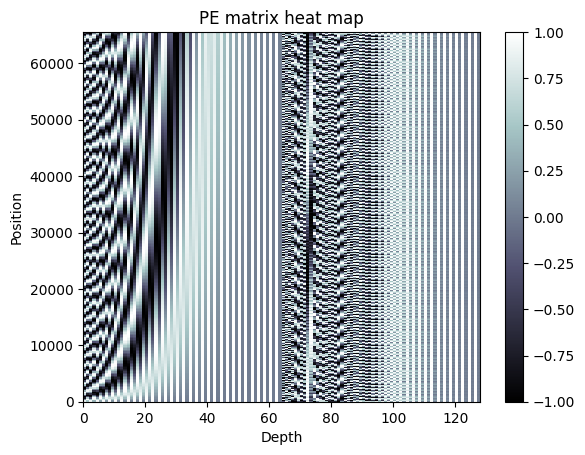

In [318]:
print(pos_enc.shape)
plt.pcolormesh(pos_enc[:,:], cmap='bone')
plt.xlabel('Depth')
# plt.xlim((0, d_model))
plt.ylabel('Position')
plt.title("PE matrix heat map")
plt.colorbar()
plt.show()

https://github.com/tatp22/multidim-positional-encoding/tree/master

In [122]:
import torch

In [134]:
def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)

class PositionalEncoding2D(torch.nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding2D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 4) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.register_buffer("cached_penc", None, persistent=False)

    def forward(self, tensor):
        """
        :param tensor: A 4d tensor of size (batch_size, x, y, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, y, ch)
        """
        if len(tensor.shape) != 4:
            raise RuntimeError("The input tensor has to be 4d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, y, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device, dtype=self.inv_freq.dtype)
        pos_y = torch.arange(y, device=tensor.device, dtype=self.inv_freq.dtype)
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        sin_inp_y = torch.einsum("i,j->ij", pos_y, self.inv_freq)
        emb_x = get_emb(sin_inp_x).unsqueeze(1)
        emb_y = get_emb(sin_inp_y)
        emb = torch.zeros(
            (x, y, self.channels * 2),
            device=tensor.device,
            dtype=tensor.dtype,
        )
        emb[:, :, : self.channels] = emb_x
        emb[:, :, self.channels : 2 * self.channels] = emb_y

        self.cached_penc = emb[None, :, :, :orig_ch].repeat(tensor.shape[0], 1, 1, 1)
        return self.cached_penc

In [198]:
n=8
positions = torch.Tensor(np.mgrid[0:n:1, 0:n:1].reshape(2,-1).T)

pos_enc_2d = PositionalEncoding2D(100)
y = torch.rand((1,n,n,100))
thing = pos_enc_2d(y).squeeze()
# thing

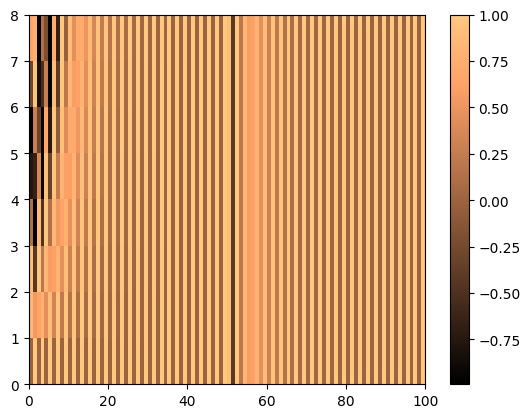

In [203]:
plt.pcolormesh(thing[:,2,:], cmap='copper')
# plt.xlabel('Depth')
# plt.xlim((0, thing.shape[2]))
# plt.ylabel('Position')
# plt.title("PE matrix heat map")
plt.colorbar()
plt.show()